# Generalisation error

In this experiment we vary the architecture of a feedforward ReLU network
and plot the (average) Bayesian generalization error as a function over the architecture.

We estimate the (average) Bayesian generalisation error as
\begin{equation}
E_n B_g(n) \approx E_n \frac{1}{n'} \sum_{i=1}^n' \log \frac{q(y_i|x_i)}{p(y_i |x_i,, \mathcal D_n)}
\end{equation}
where $\mathcal D_n$ is the training set and $n'$ is the size of the test set.



In [22]:
from __future__ import print_function
import sys
sys.path.append('../')
from main import *

class Args:

    dataset = 'ffrelu_synthetic'
    sanity_check = True
    syntheticsamplesize = 500

    network = 'ffrelu'
    VItype = 'implicit'
    batchsize = 100
    epochs = 200
    epsilon_mc = 100
    pretrainDepochs = 10
    trainDepochs = 2
    n_hidden_D = 50
    num_hidden_layers_D = 2
    n_hidden_G = 50
    num_hidden_layers_G = 2

    lr_primal = 1e-3
    lr_dual = 5e-2

    beta_auto_liberal = False
    beta_auto_conservative = False
    beta_auto_oracle = False
    betasbegin = 0.1
    betasend = 1.5
    betalogscale = True
    numbetas = 10

    elasticnet_alpha = 1.0
    R = 200

    MCs = 10

    log_interval = 50

    cuda = False

args = Args()
kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}


Making sure we satisfy the theoretical conditions, the true distribution is made to be realizable.
In particular we generate data from with input and output dimension equal to 1 and $H_1=2, H_2=1$ from the following model

```python
class ffrelu(nn.Module):
    def __init__(self,input_dim, output_dim):
        super(ffrelu, self).__init__()
        self.fc1 = nn.Linear(input_dim, H1)
        self.fc2 = nn.Linear(H1, H2)
        self.fc3 = nn.Linear(H2, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
```

In [23]:
args.input_dim = 1
args.output_dim = 1

# Currently hardcoded true hidden unit numbers
args.true_mean = models.ffrelu(args.input_dim, args.output_dim, 2, 1)

In [24]:
def train(args, train_loader, valid_loader):

    # get a grid of inverse temperatures [beta_1/log n, \ldots, beta_k/log n]
    set_betas(args)

    mc = 1
    saveimgpath = None
    nll_betas_implicit = np.empty(0)

    for beta_index in range(args.betas.shape[0]):

        # train implicit variational inference
        print('Begin training IVI')
        G = train_implicitVI(train_loader, valid_loader, args, mc, beta_index, saveimgpath)
        print('Finished training IVI')
        nllw_array_implicit = approxinf_nll_implicit(train_loader, G, args)
        nllw_mean_implicit = sum(nllw_array_implicit)/len(nllw_array_implicit)
        nll_betas_implicit = np.append(nll_betas_implicit, nllw_mean_implicit)

    ivi_robust, ivi_ols = lsfit_lambda(nll_betas_implicit, args, saveimgname=None)

    return ivi_robust

def compute_predictive_dist(args, G, loader):

    R = 1000
    eps = torch.randn(R, args.epsilon_dim)
    sampled_weights = G(eps)
    wholex = loader.dataset[:][0]
    wholey = loader.dataset[:][1]
    list_of_param_dicts = weights_to_dict(args, sampled_weights)

    pred_logprob = 0
    for param_dict in list_of_param_dicts:

        h1 = F.relu((wholex @ param_dict['W1']) + param_dict['B1'])
        h2 = F.relu((h1 @ param_dict['W2']) + param_dict['B2'])
        mean = (h2 @ param_dict['W3']) + param_dict['B3']
        pred_logprob += -(np.log(2 * np.pi) + (wholey - mean) ** 2) / 2

    return pred_logprob/R


def compute_EBg(pred_logprob,loader,args):

    wholex = loader.dataset[:][0]
    wholey = loader.dataset[:][1]
    true_logprob = -(np.log(2 * np.pi) + (wholey - args.true_mean(wholex)) ** 2) / 2

    return (true_logprob-pred_logprob).mean()

Train Epoch: 0 	Loss primal: 1.657209 	Loss dual: 0.364009 	 L_n(w) training: 1.513143 	 L_n(w) valid: 1.420885
Train Epoch: 50 	Loss primal: 1.417497 	Loss dual: 0.083458 	 L_n(w) training: 1.455930 	 L_n(w) valid: 1.388752
Train Epoch: 100 	Loss primal: 1.466569 	Loss dual: 0.085209 	 L_n(w) training: 1.456200 	 L_n(w) valid: 1.386915
Train Epoch: 150 	Loss primal: 1.387028 	Loss dual: 0.130450 	 L_n(w) training: 1.456174 	 L_n(w) valid: 1.391780
Begin training IVI
Train Epoch: 0 	Loss primal: 2.614375 	Loss dual: 0.000049 	 L_n(w) training: 1.495913 	 L_n(w) valid: 1.406486
Train Epoch: 50 	Loss primal: 1.973013 	Loss dual: 0.047721 	 L_n(w) training: 1.469029 	 L_n(w) valid: 1.397821
Train Epoch: 100 	Loss primal: 1.845241 	Loss dual: 0.304780 	 L_n(w) training: 1.489388 	 L_n(w) valid: 1.433493
Train Epoch: 150 	Loss primal: 1.694936 	Loss dual: 0.904338 	 L_n(w) training: 1.508961 	 L_n(w) valid: 1.459442
Finished training IVI
Begin training IVI
Train Epoch: 0 	Loss primal: 1.509

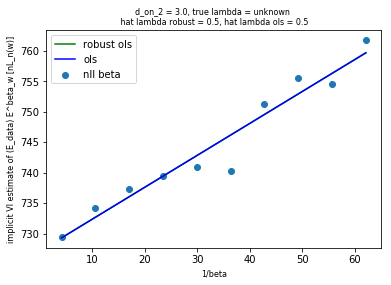

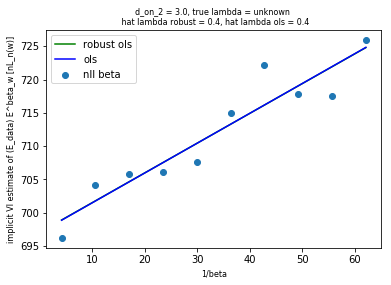

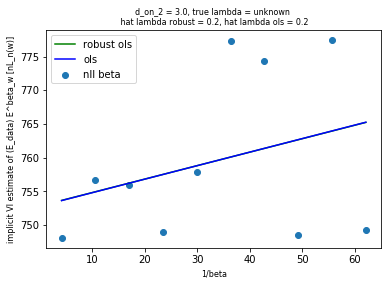

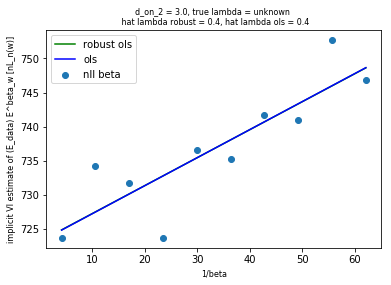

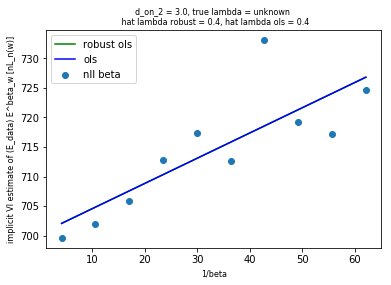

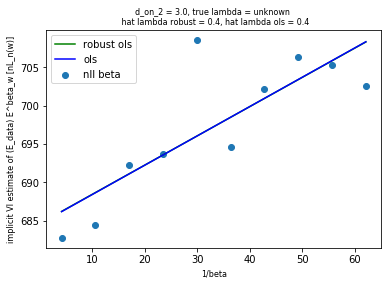

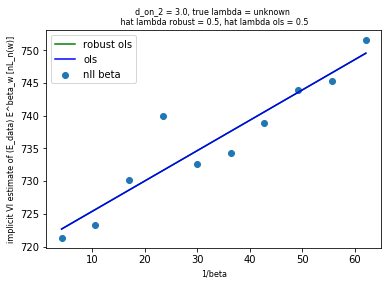

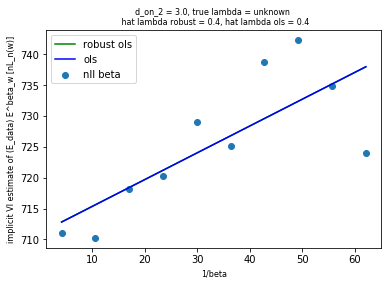

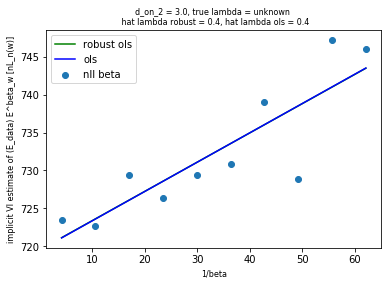

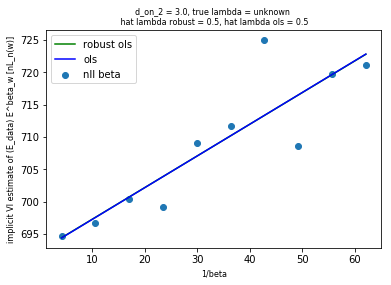

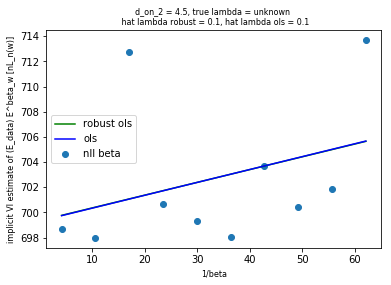

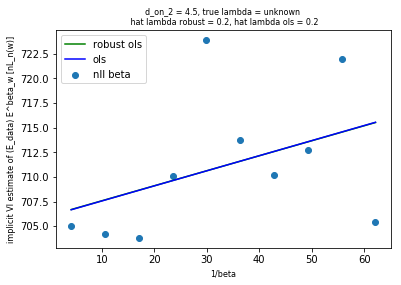

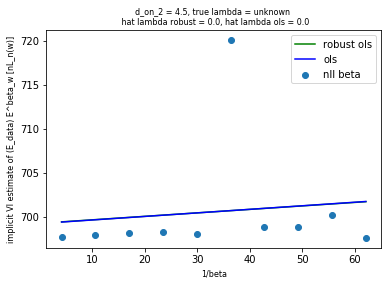

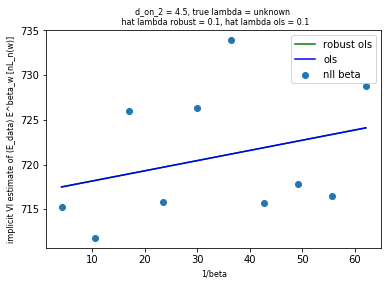

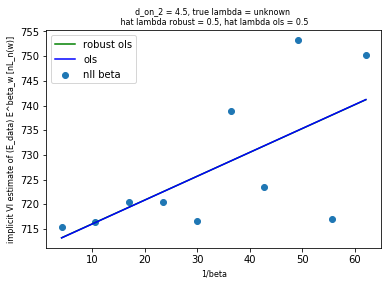

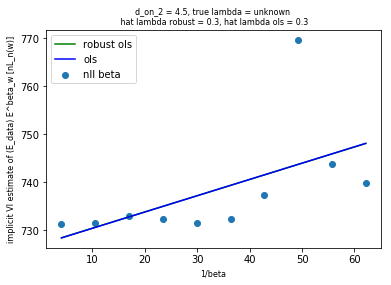

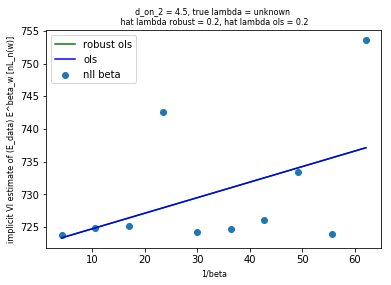

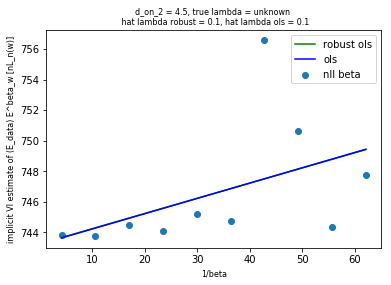

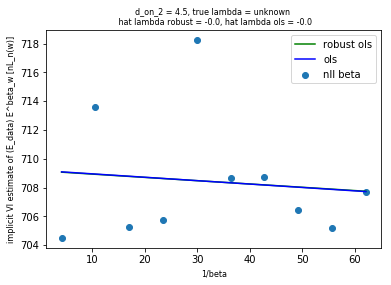

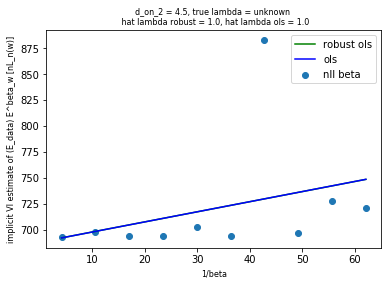

IndexError: index 2 is out of bounds for axis 1 with size 2

In [25]:
H1range = range(1,4)
H2range = range(1,3)

EBg = np.empty([len(H1range),len(H2range)])
hat_RLCT = np.empty([len(H1range),len(H2range)])

for H1 in H1range:
    for H2 in H2range:

        args.H1 = H1
        args.H2 = H2
        args.model, args.w_dim = retrieve_model(args)
        args.epsilon_dim = args.w_dim

        Bg = np.empty(args.MCs)
        rlct = np.empty(args.MCs)

        for mc in range(0,args.MCs):

            train_loader, valid_loader, test_loader = get_dataset_by_id(args, kwargs)

            args.betas = [1.0]
            beta_index = 0
            G = train_implicitVI(train_loader, valid_loader, args, mc, beta_index, saveimgpath=None)
            pred = compute_predictive_dist(args, G, test_loader)
            Bg[mc] = compute_EBg(pred,test_loader,args)

            rlct[mc] = train(args, train_loader, valid_loader)


        EBg[H1,H2] = Bg.mean()
        hat_RLCT[H1,H2] = rlct.mean()
        print('H1: {}, H2: {}'.format(H1,H2))
        print('E_n Bg(n): {}'.format(Bg.mean()))
        print('hat RLCT/n: {}'.format(rlct.mean()/args.syntheticsamplesize))

In [ ]:
EBg - hat_RLCT/args.syntheticsamplesize

